### Imporitng the required libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Mounting the drive for the source file and reading the data in dataframe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/quora_duplicate_questions.tsv',sep='\t')
df.shape

(404290, 6)

In [5]:
df.describe()


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
df.head(20)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


## Exploratory Data Analysis

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



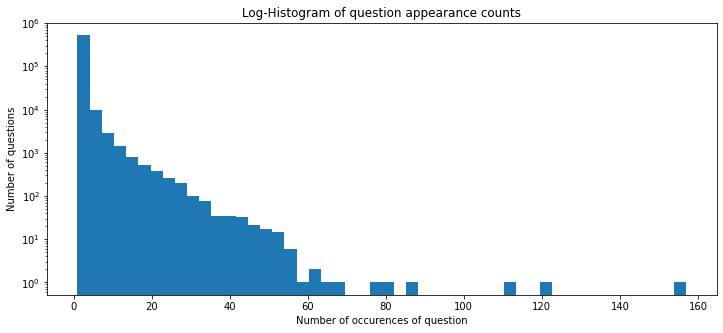

In [7]:
print('Total number of question pairs for training: {}'.format(len(df)))
print('Duplicate pairs: {}%'.format(round(df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))

print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))


plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

### Dropping the Null values


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


Text(0.5, 1.0, 'Class Distribution')

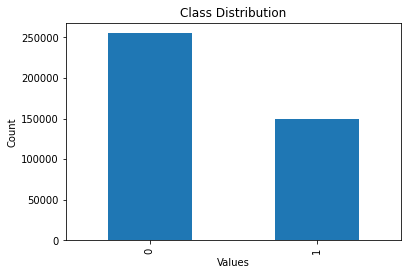

In [8]:
null = df.isnull().sum()
print(null)
df = df.dropna(subset = ['question1', 'question2'])

pd.value_counts(df['is_duplicate']).plot.bar()
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Class Distribution')

In [1]:
# !pip install tensorflow==1.15
# !pip install "tensorflow_hub>=0.6.0"
# !pip3 install tensorflow_text==1.15

     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 3.8MB 35.7MB/s 
     |████████████████████████████████| 512kB 38.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=aa8628afb99dfaf51337568b2e3ed34de07b89944739f8bbd86162da8f9cec98
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: 

## Using Universal Sentence Encoder - For creating embedding of text at sentence level

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

# creating a method for embedding and will using method for every input layer 
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]
 


In [10]:
DROPOUT = 0.1

### Building the neural network

In [11]:
# Taking the question1 as input and ceating a embedding for each question before feed it to neural network
q1 = layers.Input(shape=(1,), dtype=tf.string)
embedding_q1 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q1)
# Taking the question2 and doing the same thing mentioned above, using the lambda function
q2 = layers.Input(shape=(1,), dtype=tf.string)
embedding_q2 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q2)

# Concatenating the both input layer
merged = layers.concatenate([embedding_q1, embedding_q2])
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
pred = layers.Dense(2, activation='sigmoid')(merged)
model = Model(inputs=[q1,q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_2[0][0]                    
____________________________________________________________________________________________

In [12]:
# Pushing all the strings to a list and converting to nparray
q1= df.question1.tolist()
q2= df.question2.tolist()
labels= df.is_duplicate.tolist()

### Preparing the train and test data using Sklearn library

In [13]:
from sklearn.model_selection import train_test_split
X1 = df['question1']
X2 = df['question2']
y = df['is_duplicate']
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

train_q1 = X1_train.tolist()
train_q1 = np.array(train_q1, dtype=object)[:, np.newaxis]
train_q2 = X2_train.tolist()
train_q2 = np.array(train_q2, dtype=object)[:, np.newaxis]

train_labels = np.asarray(pd.get_dummies(y_train), dtype = np.int8)

test_q1 = X1_test.tolist()
test_q1 = np.array(test_q1, dtype=object)[:, np.newaxis]
test_q2 = X2_test.tolist()
test_q2 = np.array(test_q2, dtype=object)[:, np.newaxis]

test_labels = np.asarray(pd.get_dummies(y_test), dtype = np.int8)



### Training the model 

In [15]:
from keras.callbacks import ModelCheckpoint

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  
  filepath="/content/drive/My Drive/Quora_Duplicate/model-{epoch:02d}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint]

  model.load_weights('/content/drive/My Drive/Quora_Duplicate/model-10.hdf5')
  history = model.fit([train_q1, train_q2], 
            # train_labels,
            initial_epoch=10,
            validation_data=([test_q1, test_q2], test_labels),
            epochs=11,
            batch_size=512, callbacks=callbacks_list)
  model.save('/content/drive/My Drive/Quora_Duplicate/final_model.h5')

### Predicting the model

In [15]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras import backend as K
q1 = input("Enter Question 1 (with/without question mark): ")
q2 = input("Enter Question 2 (with/without question mark): ") 
q1 = np.array([[q1],[q1]])
q2 = np.array([[q2],[q2]])


# Using the same tensorflow session for embedding the test string
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  # Loading the save weights
  model.load_weights('/content/drive/My Drive/Quora_Duplicate/final_model.hdf5')  
  predicts = model.predict([q1, q2], verbose=0)
  predict_logits = predicts.argmax(axis=1)
  print("----FINAL RESULT----")
  if(predict_logits[0] == 1):
    print("****Questions are Similar****")
  else:
    print("****Questions are not Similar****")
  

Enter Question 1 (with/without question mark): What is your age?
Enter Question 2 (with/without question mark): How old are you?
----FINAL RESULT----
****Questions are Similar****
